In [1]:
# Volume flux driven by estuarine exchange circulation
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/xarray/core/merge.py:17: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


In [14]:
def Exchange(sd):
#sd = 20
    state01 = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/state_' + str(format(sd,'03d')) + '.nc')
    state1 = state01.isel(Y=range(1,10), T=range(40,121))
    grid = xr.open_dataset('/Users/weiyangbao/Documents/Model_outputs/Sills/grid_' + str(format(sd,'03d')) + '.nc')

    Area = np.empty([50, 9]) # Cross Y direction
    Area[:10, :] = 100
    Area[10:20, :] = 200
    Area[20:30, :] = 300
    Area[30:40, :] = 800
    Area[40:, :] = 1600
    Qsg = 700
    beta = 8e-4 # saline contraction coeff
    g = 9.8
    B = grid.Yp1.data[-2]-grid.Yp1.data[1] # fjord width
    u_x = 0.5 * (state1.U.data[:, :, :, 1:] + state1.U.data[:, :, :, :-1]) # Convert the value to grid center in x direction
    ut = u_x.mean(0) # Time averaged
    u = u_x.mean(axis=(0,2)) # dims = Z, X
    s = state1.S.data.mean(axis=(0,2))
    c = 63 # X index of the constriction point 65
    F1 = 0.2 # Froude number of the upper layer
    l = np.where(u[:, c] < 0)[-1][0] # Layer interface
#u0 = state1.U.data.mean(0)
    Q1ob = np.sum(ut[:l,:,c] * grid.HFacC.data[:l,1:-1,c] * Area[:l,:])

    h = grid.drF.data * grid.HFacC.data[:,5,c]
    h1 = h[:l].sum()
    h2 = h[l:].sum()
    u1 = np.sum(u[:l,c]*h[:l]) / h1
    s1 = np.sum(s[:l,c]*h[:l]) / h1
    s2 = np.sum(s[l:,c]*h[l:]) / h2
    mid = np.where(u[:, c-5] < 0)[-1][0]
    s2mid = np.sum(s[mid:,c-5]*h[mid:]) / h[mid:].sum()

    Q1kn = Qsg * s2 / (s2-s1)
    Q1hc = (F1*Qsg*beta*g*s2/B)**(1/3) * (B*sd/2)
    Q2hc = (F1*Qsg*beta*g*s2/B)**(1/3) * B * h1
    
    P = s2 / (s2-s1)

    return (Q1ob, Q1kn, Q1hc, Q2hc, h1, P)

In [15]:
Hs = np.array([8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]) # Sill depth [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 30, 110, 150]
r = Hs / 150

/Users/weiyangbao/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


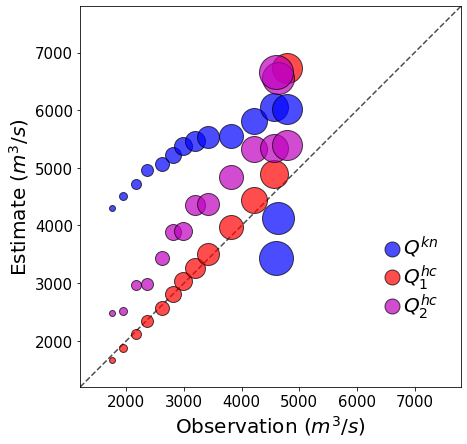

In [16]:
fig1, ax =plt.subplots(figsize=(10,7))


ax.set(xlim=(1500, 7500), ylim=(1500, 7500))
plt.axis('square')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'Observation ($m^3/s$)', size=20)
plt.ylabel(r'Estimate ($m^3/s$)', size=20)
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
loc_mark = [6600, 3600]
plt.plot(loc_mark[0],loc_mark[1], marker='o', alpha=.7, ms=15, color='b', markeredgecolor='k')
plt.text(loc_mark[0]+200, loc_mark[1]-100, r'$Q^{kn}$', fontsize=20)

plt.plot(loc_mark[0],loc_mark[1]-500, marker='o', alpha=.7, ms=15, color='r', markeredgecolor='k')
plt.text(loc_mark[0]+200, loc_mark[1]-600, r'$Q^{hc}_1$', fontsize=20)

plt.plot(loc_mark[0],loc_mark[1]-1000, marker='o', alpha=.7, ms=15, color='m', markeredgecolor='k')
plt.text(loc_mark[0]+200, loc_mark[1]-1100, r'$Q^{hc}_2$', fontsize=20)

for i in range(len(Hs)):
    Qob, Qkn, Qhc, Qhc2, h1, P = Exchange(Hs[i])
    ax.plot(Qob, Qkn, marker='o', alpha=.7, ms=2*(i+3), color='b', markeredgecolor='k')
    ax.plot(Qob, Qhc, marker='o', alpha=.7, ms=2*(i+3), color='r', markeredgecolor='k') 
    ax.plot(Qob, Qhc2, marker='o', alpha=.7, ms=2*(i+3), color='m', markeredgecolor='k') 

fig2, ax =plt.subplots(figsize=(10,7))
h1r = np.empty(len(r[:-2]))
for j in range(len(Hs[:-2])):
    Qob, Qkn, Qhc, Qhc2, h1 , P = Exchange(Hs[j])
    #h1r[j] = h1 / Hs[j]
    h1r[j] = P
plt.plot(r[:-2], h1r, 'o-', lw=2)
#ax.axhline(y=0.5,color='k',linestyle=':')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel(r'$\frac{H_s}{H}$', size=20)
#plt.ylabel(r'$\frac{H_1}{H_s}$', size=20)
plt.ylabel(r'$\frac{S_2}{\Delta S}$', size=20)



fig_path = "/Users/weiyangbao/Documents/Jupyter_Figs/Transport/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)
fig2.savefig(fig_path + '/MixingP.png', dpi = 150, bbox_inches='tight')